## Project information
I have chosen to implement Multinomial Naive Bayes Classification. Each feature in a code snippet is assumed to be independent of the other features that occurs in the same snippet. Model calculates the probability for each possible choice of programming language for a code snippet based on its feature vector and the programming language that has maximum likelihood will be the final output. Reference: `[1]`.

Code snippets are split using the Term Frequency-Inverse Document Frequency vectorizer. The number of features taken into account was selected in the tunning process.
        
I have chosen to discard the features `proj_id` and `file_id` because:
* one language can be embedded in a file containing a different language (as a string constant, for example)
* contents of the file can be changed (as well as the programming language used).

## Possible project extension
Tuning the parameters for the model:
* evaluating the model multiple times with different values of the parameters
* selecting the values for which the model performed best

Augmenting the data set using code samples found on the internet.
* larger dataset should lower the model bias
* possible pitfall - different style conventions might introduce more noise into the results.

Using a different approach to modelling the input data:
* current model looks at samples without any context, treating them as bag-of-words
* implementing the deep learning algorithm such as Long Short-Term Memory that takes into account the order for the text sequences appearances

## References
* [1] Alreshedy, Kamel, Dhanush Dharmaretnam, Daniel M. German, Venkatesh Srinivasan and T. Aaron Gulliver. “SCC: Automatic Classification of Code Snippets.” CoRR abs/1809.07945 (2018): n. pag.

In [33]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [133]:
import numpy as np
import pandas as pd
from collections import defaultdict
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.metrics import (average_precision_score, classification_report,
                             confusion_matrix, f1_score, accuracy_score, make_scorer,
                            recall_score)
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB

import config
from utils import perform_basic_analysis, read_dataset

# Reads and cleans input dataset by removing numeric characters
# and performing word tokenization and stemming.
dataset = read_dataset(config.DATASET_PATH)

Basic dataset analysis

     language  proj_id  file_id  \
0  JavaScript    10001   100001   
1  JavaScript    10001   100002   
2  JavaScript    10002   100003   
3  JavaScript    10002   100004   
4  JavaScript    10002   100005   

                                           file_body  
0  function valu variabl var cube x math.pow x va...  
1  function valu variabl var cube function x retu...  
2  function median ari ary.length return null ary...  
3                                           null . .  
4  use strict median num - num function median xs...  

Maximum number of unique languages per project: 1.0


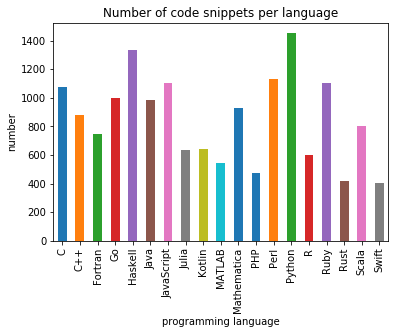

Number of code snippets per programming language
language
C              1078
C++             880
Fortran         745
Go              998
Haskell        1333
Java            987
JavaScript     1104
Julia           638
Kotlin          643
MATLAB          544
Mathematica     927
PHP             477
Perl           1136
Python         1452
R               603
Ruby           1104
Rust            417
Scala           802
Swift           404
Name: file_body, dtype: int64


In [120]:
# Perform basic dataset analysis

print('Basic dataset analysis\n')
print(dataset.head())

# How many different languages are in each project id?
dataset_grouped = dataset.groupby(['proj_id'])['language'].nunique()
max_languages_per_project = dataset_grouped.describe()['max']
print(f'\nMaximum number of unique languages per project: {max_languages_per_project}')


dt = perform_basic_analysis(dataset)
# File image name : basic_data_analysis.png

print(f'Number of code snippets per programming language')
print(dt)

In [124]:
X = dataset.file_body
y = dataset.language

# Convert a collection of code snippets into a matrix of TF-IDF features
tf = TfidfVectorizer(
    stop_words = {'english'},
    lowercase = True,
    analyzer = 'word',
)
tf_trans = TfidfTransformer()

X_counts = tf.fit_transform(X)
X_trans = tf_trans.fit_transform(X_counts)

# Calculate the total number of features
num_feature_names = len(tf.get_feature_names()) # 30321

# Keeps the information about possible number of selected features
num_features_vec = [20, 30, 40, 50, 100, 200, 300, 400, 500,
                    1000, 1100, 1200, 1300, 1400, 1500, 2000]


In [125]:
# Load model parameters
NUM_SPLITS = 10

In [134]:
print('Create, train and validate Multinomial Naive Bayes model')

mean_cv_score = defaultdict(list)

# Tuning the number of selected features
for num_features in num_features_vec:
    print(f'>> Number of selected features {num_features}')
    seed = 45
    k_fold = StratifiedKFold(n_splits = NUM_SPLITS, shuffle = True, random_state = seed)
    cv_score = defaultdict(list)
    i = 1
    X = dataset.file_body
    y = dataset.language

    # Convert a collection of code snippets to a matrix of TF-IDF features
    tf = TfidfVectorizer(
        max_features = num_features,
        stop_words = {'english'},
        lowercase = True,
        analyzer = 'word',
    )
    tf_trans = TfidfTransformer()

    for train_index, test_index in k_fold.split(X, y):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        Y_train, Y_test = y.loc[train_index], y.loc[test_index]

        # Prepare the training set
        X_train_counts = tf.fit_transform(X_train)
        X_train_trans = tf_trans.fit_transform(X_train_counts)

        # Prepare the testing set
        X_test_counts = tf.transform(X_test)
        X_test_trans = tf_trans.transform(X_test_counts)

        # Create model - Multinomial Naive Bayes Classification
        model = MultinomialNB().fit(X_train_trans, Y_train)
        Y_test_predicted = model.predict(X_test_trans)

        # Calculate basic model validation metrics
        precision, recall, fscore, support = score(Y_test, Y_test_predicted)
        accuracy = accuracy_score(Y_test, Y_test_predicted)

        # Store the values of the metrics in dictionary
        cv_score['precision'].append(precision)
        cv_score['recall'].append(recall)
        cv_score['fscore'].append(fscore)
        cv_score['support'].append(support)
        cv_score['accuracy'].append(accuracy)
        i += 1
    
    # Calculate mean values of the metrics 
    print("Precision score mean: %.3f" % np.mean(cv_score['precision']))
    print("Recall score mean: %.3f" % np.mean(cv_score['recall']))
    print("F1 score mean: %.3f" % np.mean(cv_score['fscore']))
    print("Support score mean: %.3f" % np.mean(cv_score['support']))
    print("Accuracy score mean: %.3f" % np.mean(cv_score['accuracy']))
    
    mean_cv_score['precision'].append(np.mean(cv_score['precision']))
    mean_cv_score['recall'].append(np.mean(cv_score['recall']))
    mean_cv_score['fscore'].append(np.mean(cv_score['fscore']))
    mean_cv_score['support'].append(np.mean(cv_score['support']))
    mean_cv_score['accuracy'].append(np.mean(cv_score['accuracy']))

    

Create, train and validate Multinomial Naive Bayes model
>> Number of selected features 20
Precision score mean: 0.623
Recall score mean: 0.485
F1 score mean: 0.503
Support score mean: 85.642
Accuracy score mean: 0.538
>> Number of selected features 30
Precision score mean: 0.684
Recall score mean: 0.564
F1 score mean: 0.590
Support score mean: 85.642
Accuracy score mean: 0.605
>> Number of selected features 40
Precision score mean: 0.701
Recall score mean: 0.602
F1 score mean: 0.622
Support score mean: 85.642
Accuracy score mean: 0.639
>> Number of selected features 50
Precision score mean: 0.700
Recall score mean: 0.604
F1 score mean: 0.624
Support score mean: 85.642
Accuracy score mean: 0.640
>> Number of selected features 100
Precision score mean: 0.721
Recall score mean: 0.626
F1 score mean: 0.644
Support score mean: 85.642
Accuracy score mean: 0.667
>> Number of selected features 200
Precision score mean: 0.733
Recall score mean: 0.645
F1 score mean: 0.661
Support score mean: 85.

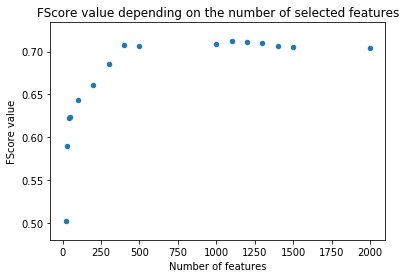

Selected number of features 1100


In [135]:
dt_results = pd.DataFrame(data = {
    'number_of_features' : num_features_vec,
    'value_of_fscore' : mean_cv_score['fscore']
})

dt_results.plot(kind = 'scatter', x = 'number_of_features', y = 'value_of_fscore')
plt.xlabel('Number of features')
plt.ylabel('FScore value')
plt.title('FScore value depending on the number of selected features')
plt.show()

# File image name fscore_vs_number_of_features.png

# Select the parameter value with the highest value of fscore metric
selected_id = mean_cv_score['fscore'].index(max(mean_cv_score['fscore']))
NUM_FEATURES = num_features_vec[selected_id]
print(f'Selected number of features {NUM_FEATURES}')

In [136]:
# Train the final model on the whole dataset

tf = TfidfVectorizer(
    max_features = NUM_FEATURES,
    stop_words = {'english'},
    lowercase = True,
    analyzer = 'word',
)
tf_trans = TfidfTransformer()
    
X_all_counts = tf.fit_transform(X)
X_all_trans = tf_trans.fit_transform(X_all_counts)
final_model = MultinomialNB().fit(X_all_trans, y)